In [1]:
import PIL.Image as Image
import numpy as np
from sms.data.utils.detic_dataloader import DeticDataloader

im_frame1 = Image.open('/home/lifelong/sms/sms/scripts/IMG_6719.jpg')
# im_frame1 = im_frame1.resize((640, 480))
np_frame1 = np.array(im_frame1)

detic = DeticDataloader()
detic.create()
detic.default_vocab()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/lifelong/anaconda3/envs/sms/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[07/31 20:30:21 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detic/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth ...
Resetting zs_weight datasets/metadata/lvis_v1_clip_a+cname.npy


In [2]:
print(np_frame1.shape)
print(np_frame1.dtype)
out = detic.predict(np_frame1)

(3024, 4032, 3)
uint8
Inference time:  0.4262669086456299


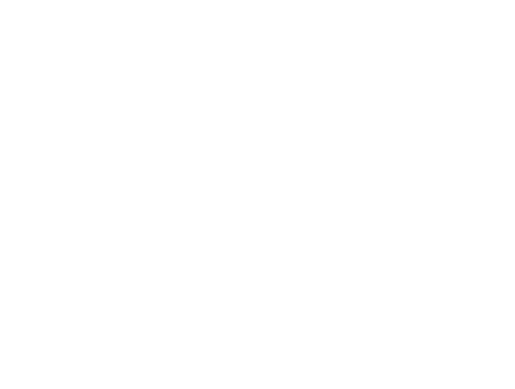

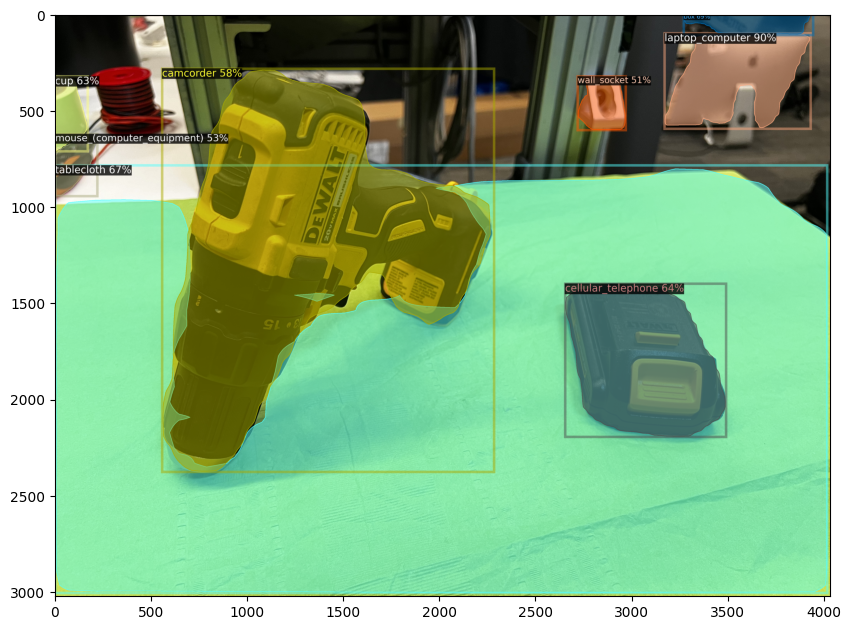

In [3]:
import matplotlib.pyplot as plt 
output_im = out['vis'].get_image()
# print(output_im.shape)
plt.axis('off')
plt.figure(figsize=(10,10))
plt.imshow(output_im)

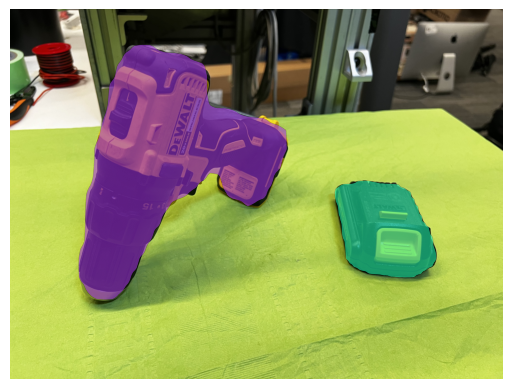

In [4]:
detic.visualize_output(np_frame1, [out['masks'][5], out['masks'][3]]) # 3 for battery

In [5]:
from sms.data.utils.dino_dataloader import DinoDataloader
import torch
dino = DinoDataloader(
    cfg= {'image_size': [640, 480]},
    device= 'cuda:0',
    image_list= None,
    use_denoiser= False,
)


Using cache found in /home/lifelong/.cache/torch/hub/facebookresearch_dinov2_main
/home/lifelong/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/home/lifelong/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/home/lifelong/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [6]:
np_frame1.shape

#downsize by factor of 4 
np_frame1_d = np_frame1[::3, ::3]
np_frame1_d.shape

(1008, 1344, 3)

In [7]:
inp = torch.from_numpy(np_frame1_d/255.0).permute(2,0,1).to(torch.float)
inp.shape

torch.Size([3, 1008, 1344])

In [8]:
out = dino.generate_dino_embed(inp)

Using cache found in /home/lifelong/.cache/torch/hub/facebookresearch_dinov2_main


In [9]:
out.shape

torch.Size([51, 68, 1024])

In [10]:

out1 = dino.get_dino_feats(inp.unsqueeze(0))


In [11]:
out1.shape

torch.Size([1, 56, 75, 1024])

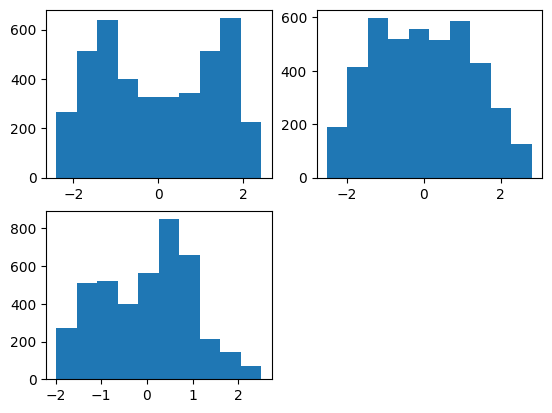

In [12]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Seperate Background
# sklearn expects 2d array for traning
# total_features = total_features.reshape(4 * out1.shape[1] * out1.shape[2], 1024) #4(*H*w, 1024)
patch_h = out1.shape[1]
patch_w = out1.shape[2]
total_features = out1.squeeze(0).squeeze(0).reshape(-1, 1024)
pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# visualize PCA components for finding a proper threshold
# 3 histograms for 3 components
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()
     

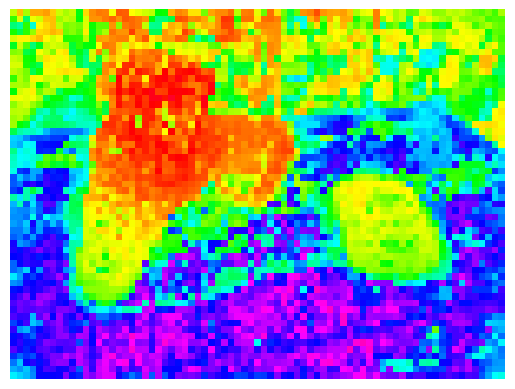

In [13]:
# min_max scale
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / \
                     (pca_features[:, 0].max() - pca_features[:, 0].min())
#pca_features = sklearn.processing.minmax_scale(pca_features)

# plt.subplot(2, 2, i+1)
plt.imshow(pca_features[0 : patch_h*patch_w, 0].reshape(patch_h, patch_w), cmap='gist_rainbow')
plt.axis('off')
plt.savefig('pca1.png', bbox_inches='tight')
plt.show()

In [14]:
from sms.data.utils.pyramid_embedding_dataloader import PyramidEmbeddingDataloader

clip = PyramidEmbeddingDataloader(
    cfg={
            },
    device= 'cuda:0',
    image_list= None,
)


inside init Pyramid Process


: 